In [ ]:
!pip install pydicom

import os
import cv2
import math
import numpy as np
import pydicom as pdcm
from skimage.draw import polygon
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt

In [ ]:
XML_PATH = "path to XML folder"
DCM_PATH = "path to DICOM folder"
img_name = "22670809"

In [ ]:
class Annotation:
  
  def __init__(self, xml_path, filename, shape):

    self.xml_path = xml_path + filename + '.xml'
    self.mask     = self.create_mask_array(shape)
    self.fill_mask()


  """
  This function creates the proper contour/polygon for each ROI and stores
  the information in the corresponding position of the mask object
  """
  def fill_mask(self):
    if os.path.exists(self.xml_path):
      rois, num_rois   = self.parse_XML(self.xml_path)

      for roi in rois:
        roi_info       = self.get_roi_info(roi)
        r_poly, c_poly = self.create_polygon_lists(self.mask, roi_info["points"])
        rr, cc         = polygon(r_poly, c_poly)
        roi_channel    = self.select_mask_channel(roi_info["roi_type"])
        try:
          self.mask[rr, cc, roi_channel] = 1
        except IndexError:
          print(self.xml_path)


  """
  Inputs:
    -- xml_path: Path to the corresponding xml file
  Outputs:
    -- rois: Array with the ROI objects
    -- num_of_rois: Number of ROIs 
  """
  def parse_XML(self, xml_path):
    tree        = ET.parse(xml_path)
    root        = tree.getroot()       # The root of the XML file
    data        = root[0][1]           # The essential info
    rois        = data[0][5]           # Array containing the ROI objects
    num_of_rois = int(data[0][3].text) # Number of ROI objects

    return rois, num_of_rois


  """
  Inputs:
    -- img_shape: The preferred shape of the mask to be created
  Outputs:
    -- 3-dimensional numpy array of type uint8 
  """
  def create_mask_array(self,img_shape):
    return np.zeros((img_shape[0], img_shape[1], 3), dtype = np.uint8)

  def get_roi_info(self, roi):
    roi_info      = {
      "points":        roi[21],           # Array containing the points of a ROI
      "num_of_points": int(roi[17].text), # Number of points of the area
      "roi_index":     int(roi[7].text),  # Identifier of the ROI
      "roi_type":      roi[15].text       # (Mass, Calcification, other)
    }

    return roi_info



  """
  Inputs:
    -- mask: numpy object of the mask
    -- points: x-y coordinates of a ROI's points
  Outputs:
    -- r_poly: array containing the x-axis coordinates
    -- c_poly: array containing the y-axis coordinates
  """
  def create_polygon_lists(self, mask, points):
    mask_width  = mask.shape[0]
    mask_height = mask.shape[1]
    r_poly      = np.array([])
    c_poly      = np.array([])
    roi_img     = np.zeros((mask_width, mask_height), dtype=np.uint8)

    for point in points:

      temp_tuple = point.text[1:-1].split(",")
      y          = int(math.trunc(float(temp_tuple[0]))) 
      x          = int(math.trunc(float(temp_tuple[1])))
      r_poly     = np.append(r_poly, x)
      c_poly     = np.append(c_poly, y)

    return r_poly, c_poly


  """
  Input:
    -- roi_type: The type of a specific ROI, extracted from the XML file
  Output:
    -- roi_channel: The type of the ROI defines the integer value of this var
  """
  def select_mask_channel(self, roi_type):
    roi_ch = 2
    if roi_type == "Mass":
      roi_ch = 0
    elif roi_type == "Calcification":
      roi_ch = 1
    return roi_ch


In [ ]:
dcm = pdcm.dcmread(DCM_PATH + img_name + '.dcm')
img = dcm.pixel_array
print(img.shape)
a   = Annotation(XML_PATH, img_name, img.shape)

(4084, 3328)


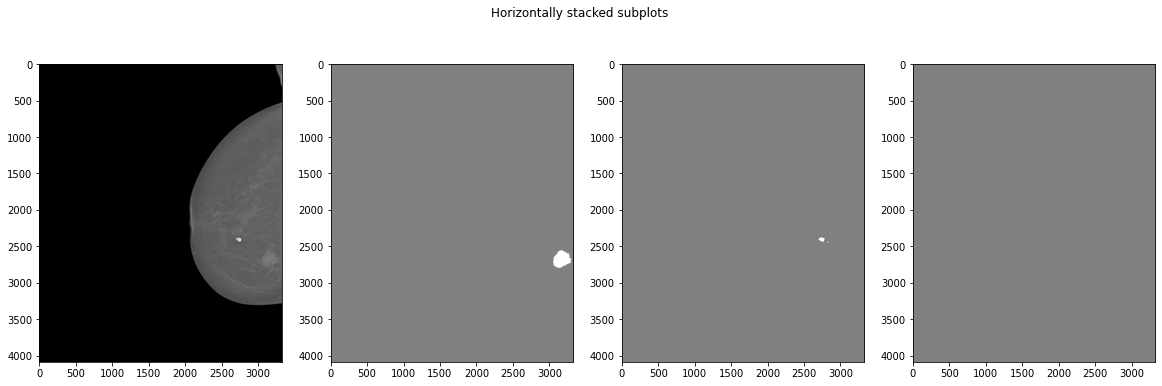

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_figheight(6)
fig.set_figwidth(20)
fig.suptitle('Horizontally stacked subplots')

ax1.imshow(img, cmap='gray')
ax2.imshow(a.mask[:,:,0], cmap='gray', alpha=0.5)
ax3.imshow(a.mask[:,:,1], cmap='gray', alpha=0.5)
ax4.imshow(a.mask[:,:,2], cmap='gray', alpha=0.5)